In [81]:
# imports
import hmmlearn
from hmmlearn import hmm
from hmmlearn import vhmm
import numpy as np
import csv 
import pandas as pd
import matplotlib.pyplot as plt
import math
import re
import pickle
import seaborn as sns
from datetime import datetime

# Reading in the data

In [9]:
raw_df = pd.read_csv('~/UROP_transportation/data/I80_density.csv').dropna(axis=0)
raw_df.columns
all_columns = ['400126', '400176', '400691', '401242', '401698',
       '405602']

In [18]:
class Data():
    def __init__(self, columns, normalize=True):
        self.columns = columns
        self.normalize = normalize
        
        raw_df = pd.read_csv('~/UROP_transportation/data/I80_density.csv').dropna(axis=0)

        if normalize: # normalize data
            time_cache = {}
            for date in raw_df['Unnamed: 0']:
                time = date[-8:]
                if time not in time_cache:
                    mask = raw_df['Unnamed: 0'].str.contains(time)
                    same_time_df = raw_df[mask]
                    for column in self.columns:
                        # Calculate mean and standard deviation of the filtered values
                        mean_value = same_time_df[column].mean()
                        std_value = same_time_df[column].std()
                        # Apply z-score normalization to the 'Column' using the mean and standard deviation
                        normalized_values = (same_time_df[column] - mean_value) / std_value
                        # Assign the normalized values back to the DataFrame
                        raw_df.loc[raw_df['Unnamed: 0'].str.contains(time), column] = normalized_values
                time_cache[time] = 1

        self.dataframe = raw_df[columns]
        self.array = np.array(self.dataframe)

    def split_data(self, split):
        n_samples = self.array.shape[0]
        n_features = self.array.shape[1]

        num_training_points = math.floor(n_samples * split)
        self.training = self.array[0:num_training_points]
        self.testing = self.array[num_training_points:]
        
    def plot_flow_correlations(self):
        fig, ax = plt.subplots(figsize=(8,8))
        heatmap = ax.imshow(self.dataframe.corr())
        ax.set(xticks=[], yticks=[]);
        cbar = fig.colorbar(heatmap, ax=ax, shrink=0.8)
        plt.title('Segment Travel Time Correlations')
        plt.show()

# correlation heatmaps

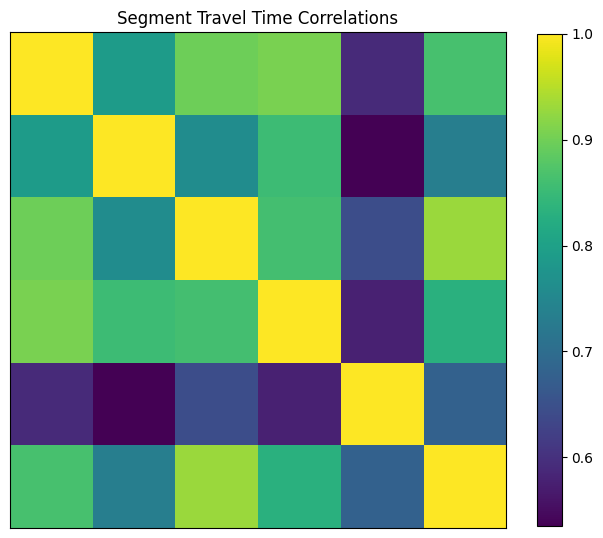

In [16]:
periodic_data = Data(columns = all_columns, normalize=False)
periodic_data.plot_flow_correlations()

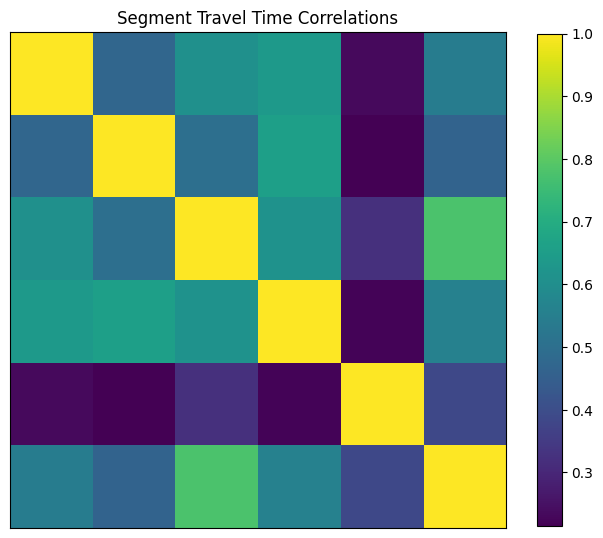

In [19]:
aperiodic_data = Data(columns = all_columns, normalize=True)
aperiodic_data.plot_flow_correlations()

# Setting up architecture

We set up a Hidden Markov model with a multivariate Gaussian emission function. The latent variable here are the states of the underlying Markov chain, which could possibly encode incidents. Right now I don't expect the model to work super well, because in the HMM, the observed (emission) traffic flows do not depend on each other, only on the underlying state of traffic, which in turn only depends on the previous traffic state. Perhaps for n segments of roads, O(n!) states would be sufficient for capturing relative order of traffic flows. Perhaps Gaussian emissions also doesn't make much sense with a discrete set of hidden states. Thus we will look into coding up a Linear Dynamical System (LDS) to capture continuous hidden states (with linear evolution + small Gaussian noise), and ideally the traffic flow emissions from continuous hidden states makes more sense. 

One downside to encoding traffic states as hidden states is that the model is less interpretable - it is unclear what kinds of states these traffic states are referring to, and we need many in order to get a reasonable accuracy. If we include certain latent variables encoding incidents into the hidden states, again it's not clear what our underlying structure between incidents and non-incidents should be.

In [135]:
# define custom type class VHMM model - each object is a model tied together with training data, testing data, predictions, etc.
# convenient to couple together model with associated scores/datasets/predictions

# design choices: 
    # want to keep passing in training_data and testing_data directly
    # rather than including methods for processing and splitting gtraining data, 
    # because potentially want to test on data from a different dataset (i.e. incidents)

class VHMM_Model():
    def __init__(self, num_components, covar_type, training_data=None, testing_data=None):
        """num_components: int, numbre of components
        covar_type: str, covariance type for model
        training and testing data: np.array types """
        self.num_components = num_components
        self.covar_type = covar_type
        self.training_data = training_data
        self.testing_data = testing_data
        self.n_samples = len(training_data) + len(testing_data)
        self.model = hmmlearn.vhmm.VariationalGaussianHMM(n_components=self.num_components, covariance_type=self.covar_type)
        self.score = None
        self.predicted_states_training = None
        self.predicted_states_testing = None
        self.predicted_flows_training = None
        self.predicted_flows_testing = None
        
    def train_model(self):
        converged = False
        while not converged:
            (self.model).fit(self.training_data, [len(self.training_data)])
            converged = (self.model).monitor_.converged
            if converged == False:
                print(f'model not converging for for num_components = {self.num_components}')
        return self.model
    
    def compute_score(self):
        self.score = (self.model).score(self.testing_data, [len(self.testing_data)])    
        return self.score
    
    def predict_states_and_flows(self):
        # self.model.means_ = list of means of gaussian emissions, indexed by state number
        self.predicted_states_training = self.model.predict(self.training_data, [len(self.training_data)])
        self.predicted_states_testing = self.model.predict(self.testing_data, [len(self.testing_data)])
        self.predicted_flows_training = [self.model.means_[state] for state in self.predicted_states_training]
        self.predicted_flows_testing = [self.model.means_[state] for state in self.predicted_flows_testing]
    
    def get_predicted_flows(self, column, train_or_test='test'):
        """column: str, column to get predicted flows for
        train_or_test: str in {'train', 'test'}, specify which dataset to predict flows for"""
    
        col_strings_to_index = {'400126': 0,
                           '400176': 1, 
                           '400691': 2,
                           '401242': 3,
                           '401698': 4,
                           '405602': 5}
        col_index = col_strings_to_index[column]
        if train_or_test == 'train':
            predicted_mean_flows = [flow[col_index] for flow in self.predicted_flows_training]
            return predicted_mean_flows
        # default to predicting flows on testing data
        predicted_mean_flows = [flow[col_index] for flow in self.predicted_flows_testing]
        return predicted_mean_flows
    
    def plot_predicted_flows(self, column, time_range, train_or_test='test'):
        # time_range = tuple, range of teimstesp to predict flo
        plt.figure(figsize=(25, 15), layout ='constrained')
        if train_or_test == 'training':
            selected_predicted_mean_flows = [flow[col_index] for flow in self.predicted_flows_training[time_range[0]:time_range[1]]]
            actual_flows = raw_df[column].tolist()[time_range[0]:time_range[1]]
        else:
            selected_predicted_mean_flows = [flow[col_index] for flow in self.predicted_flows_testing[time_range[0]:time_range[1]]]
            actual_flows = raw_df[column].tolist()[len(self.training_data)+time_range[0]:len(self.training_data)+time_range[1]]
        plt.plot(selected_predicted_mean_flows, color='red', label='predicted traffic flow means')
        plt.plot(actual_flows, color='blue', label='actual traffic flows')
        plt.xlabel('time')
        plt.ylabel('traffic flow')
        plt.title("Traffic flow predictions on segments " + str(column))
        plt.legend()
        plt.show()
    
    def plot_transmat(self):
        ax = sns.heatmap(self.model.transmat_, linewidth=0.5)
        plt.show()

In [175]:
def train_all_models(multiplicity, num_components_range, covar_type, columns, train_test_split, normalize=False): 
    """
    trains multiplicity # of models for each num_components in num_components_range
    params:
        multiplicity: int, number of models for each # of components
        num_components_range: tuple, range for number of componenets in 
        covar_type: string, covariance type
        columns: list, column names
        train_test_split: float, between 0 and 1, proportion of data used for training
        noralized: boolean, whether or not normalizing flow data across days to remove periodicity
    returns:
        all_models: dictionary of lists, keys are num_components
            and values are lists of length multiplicity, elts models with num_components components
    """
    selected_data = Data(columns, normalize)
    selected_data.split_data(train_test_split)
    
    all_models = {num_components: [] for num_components in range(num_components_range[0], num_components_range[1])}
    for num_components in range(num_components_range[0], num_components_range[1]):
        for i in range(multiplicity):
            model = VHMM_Model(num_components, covar_type, selected_data.training, selected_data.testing)
            all_models[num_components].append(model)
            model.train_model()
            model.compute_score()
            # track times taken to train each model
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
            print(f'done training model {i} with {num_components} components \n' + f'score = {model.score} \n' + f"current time = {current_time} \n" + "-------------")
        print(f'done training all models with {num_components} components \n' + "------------- \n" + "------------- \n")
    print('done training all models \n' + "-------------")
    
    return all_models
    
def plot_model_scores(all_models):
    # all_models: dictionary, keys = num_componenets & values = (trained) models
    fig, ax = plt.subplots(figsize=(15, 10), layout ='constrained')
    components = []
    scores = []
    for num_components in all_models:
        for model in all_models[num_components]:
            components.append(num_components)
            scores.append(model.score) 
    ax.plot(components, scores, 'bo')
    ax.set_xlabel('num_components')
    ax.set_ylabel('log-likehood score of model')
    ax.set_title("Log-likehood for different number of components")
    return fig, ax

In [162]:
def save_to_pickles(all_models):
    """save the best scoring models to pickles"""
    for num_components in all_models:
        model_score_array = np.array([model.score for model in all_models[num_components]])
        best_model_index = np.argmax(model_score_array)
        best_model = all_models[num_components][best_model_index]
        
        filename = 'model_' + str(num_components) + '_components.pickle'
        filehandler = open(filename, 'wb') 
        pickle.dump(model, filehandler)
        print(f'saved model with {num_components} components to pickle file')

# creating and testing models

In [163]:
# normalized
selected_cols = ['400126','400176','400691','401242']
all_models = train_all_models(5, (5,25), covar_type="full", columns=selected_cols, train_test_split=0.7, normalize=False) 

Model is not converging.  Current: 2056582.5549880764 is not greater than 2056582.55499201. Delta is -3.9334408938884735e-06


done training model 0 with 5 components 
score = 659035.447643831 
current time = 13:05:20 
-------------


Model is not converging.  Current: 2060612.867898551 is not greater than 2060612.8678992994. Delta is -7.48317688703537e-07


done training model 1 with 5 components 
score = 662748.1191183382 
current time = 13:05:57 
-------------
done training model 2 with 5 components 
score = 662748.8846496624 
current time = 13:06:31 
-------------
done training model 3 with 5 components 
score = 658212.0155982504 
current time = 13:07:11 
-------------
done training model 4 with 5 components 
score = 650864.1163014695 
current time = 13:07:51 
-------------
done training all models with 5 components 
------------- 
------------- 

done training model 0 with 6 components 
score = 672444.8197032822 
current time = 13:08:42 
-------------
done training model 1 with 6 components 
score = 661527.4373780607 
current time = 13:09:36 
-------------
done training model 2 with 6 components 
score = 662750.1127424712 
current time = 13:10:32 
-------------
done training model 3 with 6 components 
score = 662759.6852736438 
current time = 13:11:27 
-------------


Model is not converging.  Current: 2060021.869070889 is not greater than 2060021.869070924. Delta is -3.4924596548080444e-08


done training model 4 with 6 components 
score = 662753.4743140604 
current time = 13:12:11 
-------------
done training all models with 6 components 
------------- 
------------- 

done training model 0 with 7 components 
score = 664452.0790468283 
current time = 13:13:17 
-------------
done training model 1 with 7 components 
score = 670374.438001339 
current time = 13:14:20 
-------------
done training model 2 with 7 components 
score = 679938.3937865831 
current time = 13:15:39 
-------------
done training model 3 with 7 components 
score = 664626.2543301781 
current time = 13:16:57 
-------------
done training model 4 with 7 components 
score = 679904.6320358219 
current time = 13:18:05 
-------------
done training all models with 7 components 
------------- 
------------- 

done training model 0 with 8 components 
score = 683866.782104355 
current time = 13:19:24 
-------------
done training model 1 with 8 components 
score = 680199.4278168124 
current time = 13:20:42 
----------

done training model 1 with 20 components 
score = 685509.97935636 
current time = 16:19:35 
-------------
done training model 2 with 20 components 
score = 708902.3458251979 
current time = 16:24:46 
-------------
done training model 3 with 20 components 
score = 694592.6523408812 
current time = 16:29:57 
-------------
done training model 4 with 20 components 
score = 689951.1176272263 
current time = 16:35:12 
-------------
done training all models with 20 components 
------------- 
------------- 

done training model 0 with 21 components 
score = 695981.3358385746 
current time = 16:40:50 
-------------
done training model 1 with 21 components 
score = 697077.5624587229 
current time = 16:46:31 
-------------
done training model 2 with 21 components 
score = 692038.0923472872 
current time = 16:52:15 
-------------
done training model 3 with 21 components 
score = 700624.9447123134 
current time = 16:57:51 
-------------
done training model 4 with 21 components 
score = 687105.15961

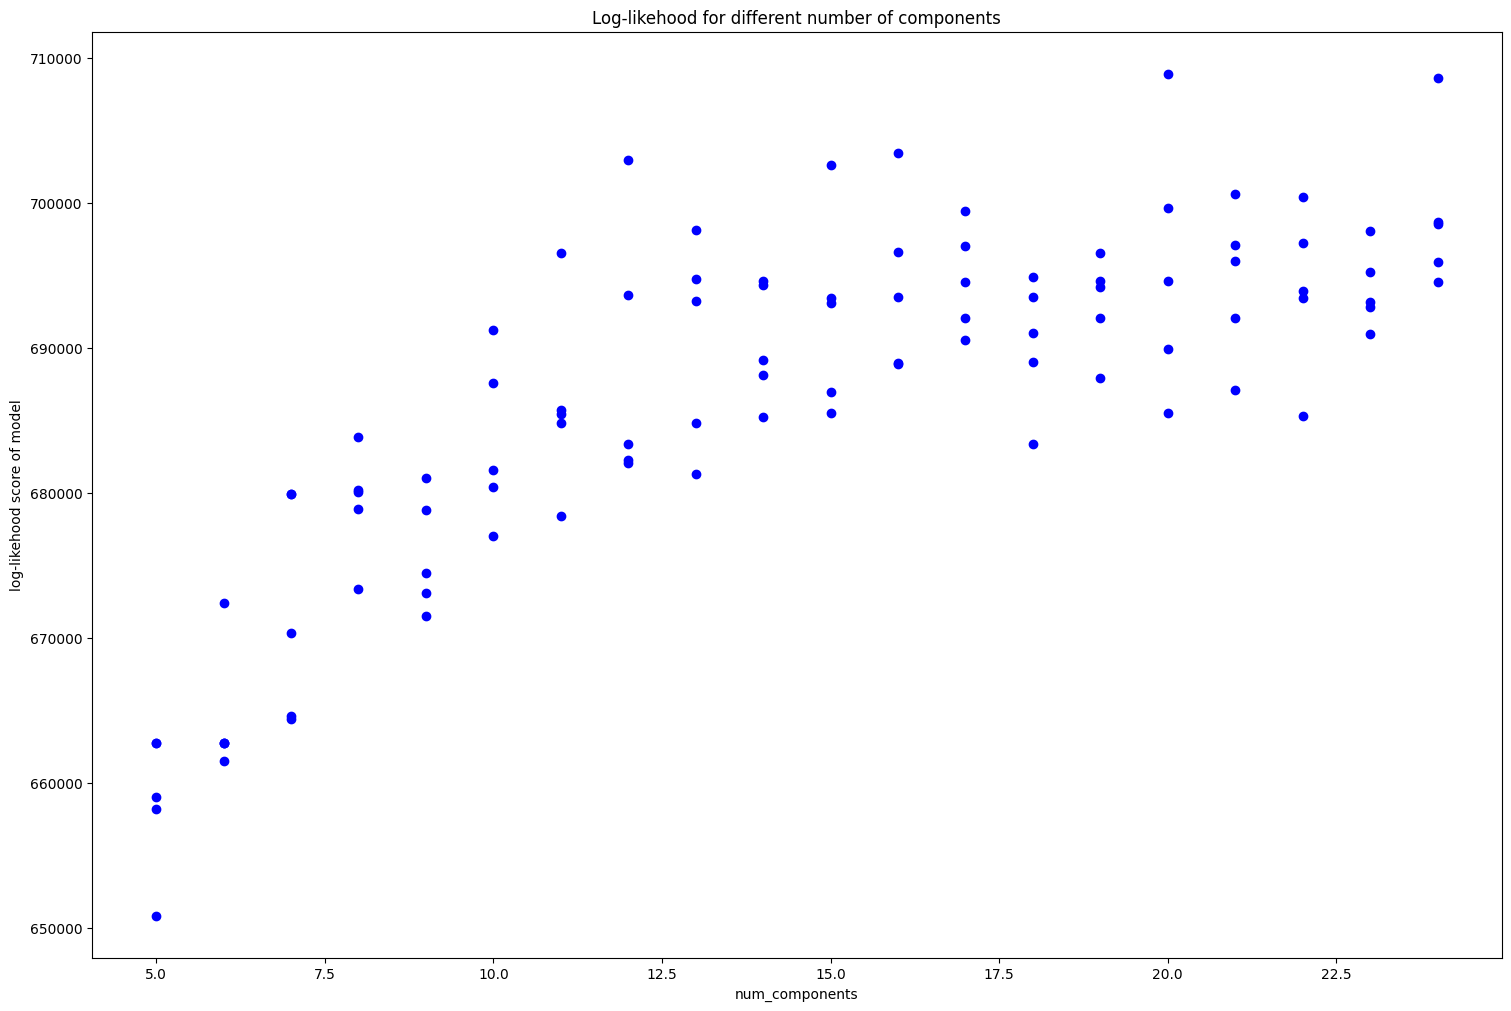

In [183]:
scores_fig = plot_model_scores(all_models)
scores_fig[0].savefig('all_model_scores_no_normalization.png', dpi=200)

In [181]:
save_to_pickles(all_models)

saved model with 5 components to pickle file
saved model with 6 components to pickle file
saved model with 7 components to pickle file
saved model with 8 components to pickle file
saved model with 9 components to pickle file
saved model with 10 components to pickle file
saved model with 11 components to pickle file
saved model with 12 components to pickle file
saved model with 13 components to pickle file
saved model with 14 components to pickle file
saved model with 15 components to pickle file
saved model with 16 components to pickle file
saved model with 17 components to pickle file
saved model with 18 components to pickle file
saved model with 19 components to pickle file
saved model with 20 components to pickle file
saved model with 21 components to pickle file
saved model with 22 components to pickle file
saved model with 23 components to pickle file
saved model with 24 components to pickle file


In [185]:
file = open('model_24_components.pickle', 'rb')
best_model_24_components = pickle.load(file)
best_model_24_components.predict_states_and_flows()
column = '400126'
best_model_24_components.get_predicted_flows(column, train_or_test='test')
best_model_24_components.plot_predicted_flows(column, (0,50), train_or_test='test')


TypeError: 'NoneType' object is not iterable

# creating and testing models

In [151]:
# setting up data
selected_cols = ['400126','400176','400691','401242']
# testing out up to 24 hidden states --> possibly all 4! = 24 permutations of the 4 travel segments needed for accurate predictions

    

done training model <__main__.VHMM_Model object at 0x14011adc0> 
score = 682857.234312084 
current time = 01:47:46 
-------------
done training model <__main__.VHMM_Model object at 0x140c58760> 
score = 701528.3481568879 
current time = 01:51:10 
-------------
done training model <__main__.VHMM_Model object at 0x140108250> 
score = 688361.8687635473 
current time = 01:54:55 
-------------
done training model <__main__.VHMM_Model object at 0x14058f070> 
score = 692701.8158768262 
current time = 01:59:06 
-------------
done training model <__main__.VHMM_Model object at 0x14058f0a0> 
score = 699078.4983791147 
current time = 11:46:41 
-------------
done training model <__main__.VHMM_Model object at 0x14058f670> 
score = 689129.951867583 
current time = 11:52:29 
-------------
done training model <__main__.VHMM_Model object at 0x14058f7c0> 
score = 694245.7986682549 
current time = 11:57:42 
-------------
done training model <__main__.VHMM_Model object at 0x14058ff70> 
score = 696934.03632

In [153]:
# filename = 'model_15_components.pickle'
# filehandler = open(filename, 'wb')
# pickle.dump(all_models[15], filehandler)

for num_components in models[0]:
    model = models[0][num_components] 
    filename = 'model_' + str(num_components) + '_components.pickle'
    filehandler = open(filename, 'wb') 
    pickle.dump(model, filehandler)

In [ ]:
for i in range(1,5):
    models.append(train_all_models(num_components_range=(15,25), covar_type='full', columns=selected_cols, train_test_split=0.7, normalize=False))
    for num_components in models[i]:
    model = models[0][num_components] 
    filename = 'model_' + str(num_components) + '_components.pickle'
    filehandler = open(filename, 'wb') 
    pickle.dump(model, filehandler)

In [85]:
# setting up data
selected_cols = ['400126','400176','400691','401242']
# testing out up to 24 hidden states --> possibly all 4! = 24 permutations of the 4 travel segments needed for accurate predictions
normalized_models = []
normalized_models.append(train_all_models(num_components_range=(15,25), covar_type='full', columns=selected_cols, train_test_split=0.7, normalize=True))

done training model <__main__.VHMM_Model object at 0x12cc0e040> 
score = 696999.2840991316 
current time = 12:07:04 
-------------
done training model <__main__.VHMM_Model object at 0x12cc0edc0> 
score = 704007.653609825 
current time = 12:10:58 
-------------
done training model <__main__.VHMM_Model object at 0x12d003610> 
score = 690127.0104547618 
current time = 12:15:16 
-------------
done training model <__main__.VHMM_Model object at 0x12d0030d0> 
score = 692327.3599338853 
current time = 12:20:53 
-------------
done training model <__main__.VHMM_Model object at 0x12d003640> 
score = 692350.6507471215 
current time = 12:26:20 
-------------
done training model <__main__.VHMM_Model object at 0x12d0035b0> 
score = 690816.9434737707 
current time = 12:30:51 
-------------
done training model <__main__.VHMM_Model object at 0x12d0033d0> 
score = 698124.6150093646 
current time = 12:35:56 
-------------
done training model <__main__.VHMM_Model object at 0x12d003250> 
score = 699189.3651

In [129]:
print(all_models)

{15: <__main__.VHMM_Model object at 0x12cc0e040>, 16: <__main__.VHMM_Model object at 0x12cc0edc0>, 17: <__main__.VHMM_Model object at 0x12d003610>, 18: <__main__.VHMM_Model object at 0x12d0030d0>, 19: <__main__.VHMM_Model object at 0x12d003640>, 20: <__main__.VHMM_Model object at 0x12d0035b0>, 21: <__main__.VHMM_Model object at 0x12d0033d0>, 22: <__main__.VHMM_Model object at 0x12d003250>, 23: <__main__.VHMM_Model object at 0x12de67310>, 24: <__main__.VHMM_Model object at 0x12de67ac0>}


In [ ]:
plt.plot(xdata, ydata, 'or')
       plt.plot(xfit, yfit, '-', color='gray')

       plt.fill_between(xfit, yfit - dyfit, yfit + dyfit,
                        color='gray', alpha=0.2)
       plt.xlim(0, 10);

In [131]:
filename = 'model_15_componenets.pickle'
filehandler = open(filename, 'w')
pickle.dump(all_models[15], filehandler)

PicklingError: Can't pickle <class '__main__.VHMM_Model'>: it's not the same object as __main__.VHMM_Model

In [128]:
for key in all_models.keys():
    filename = 'model_' + str(key) + 'components.pickle'
    filehandler = open(filename, 'w') 
    pickle.dump(all_models[key], filehandler)

PicklingError: Can't pickle <class '__main__.VHMM_Model'>: it's not the same object as __main__.VHMM_Model

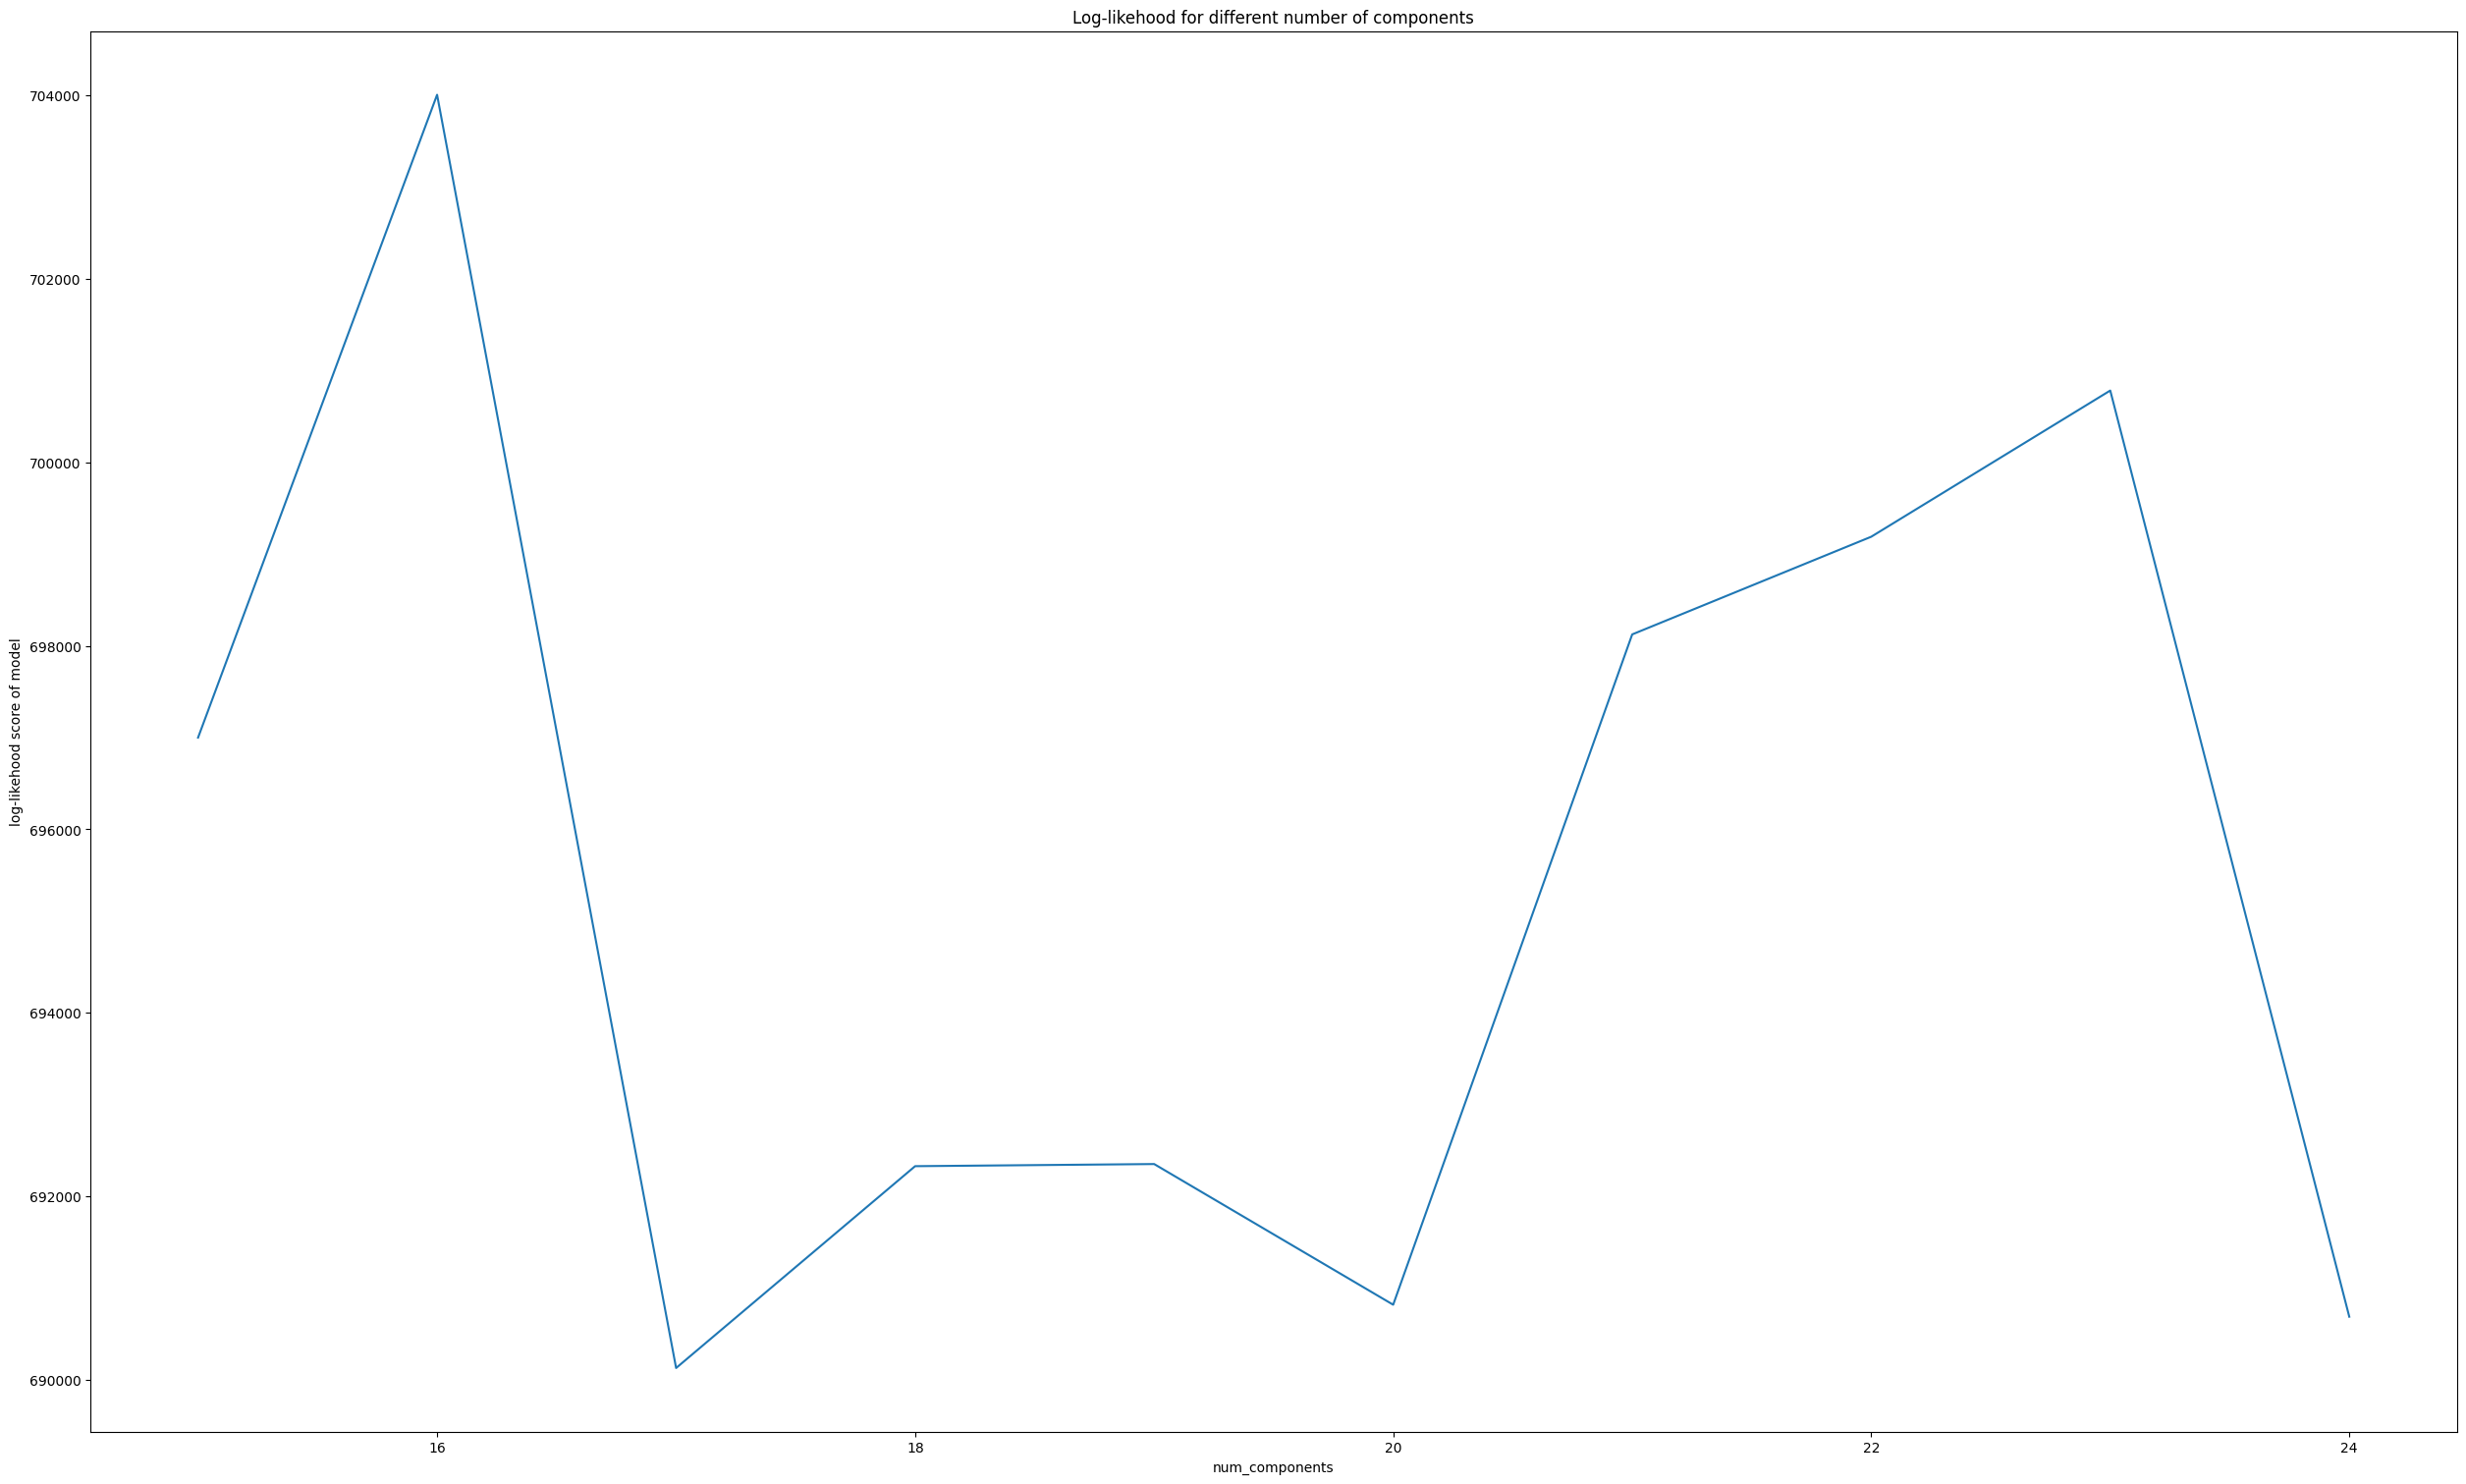

In [95]:
plot_model_scores(all_models)

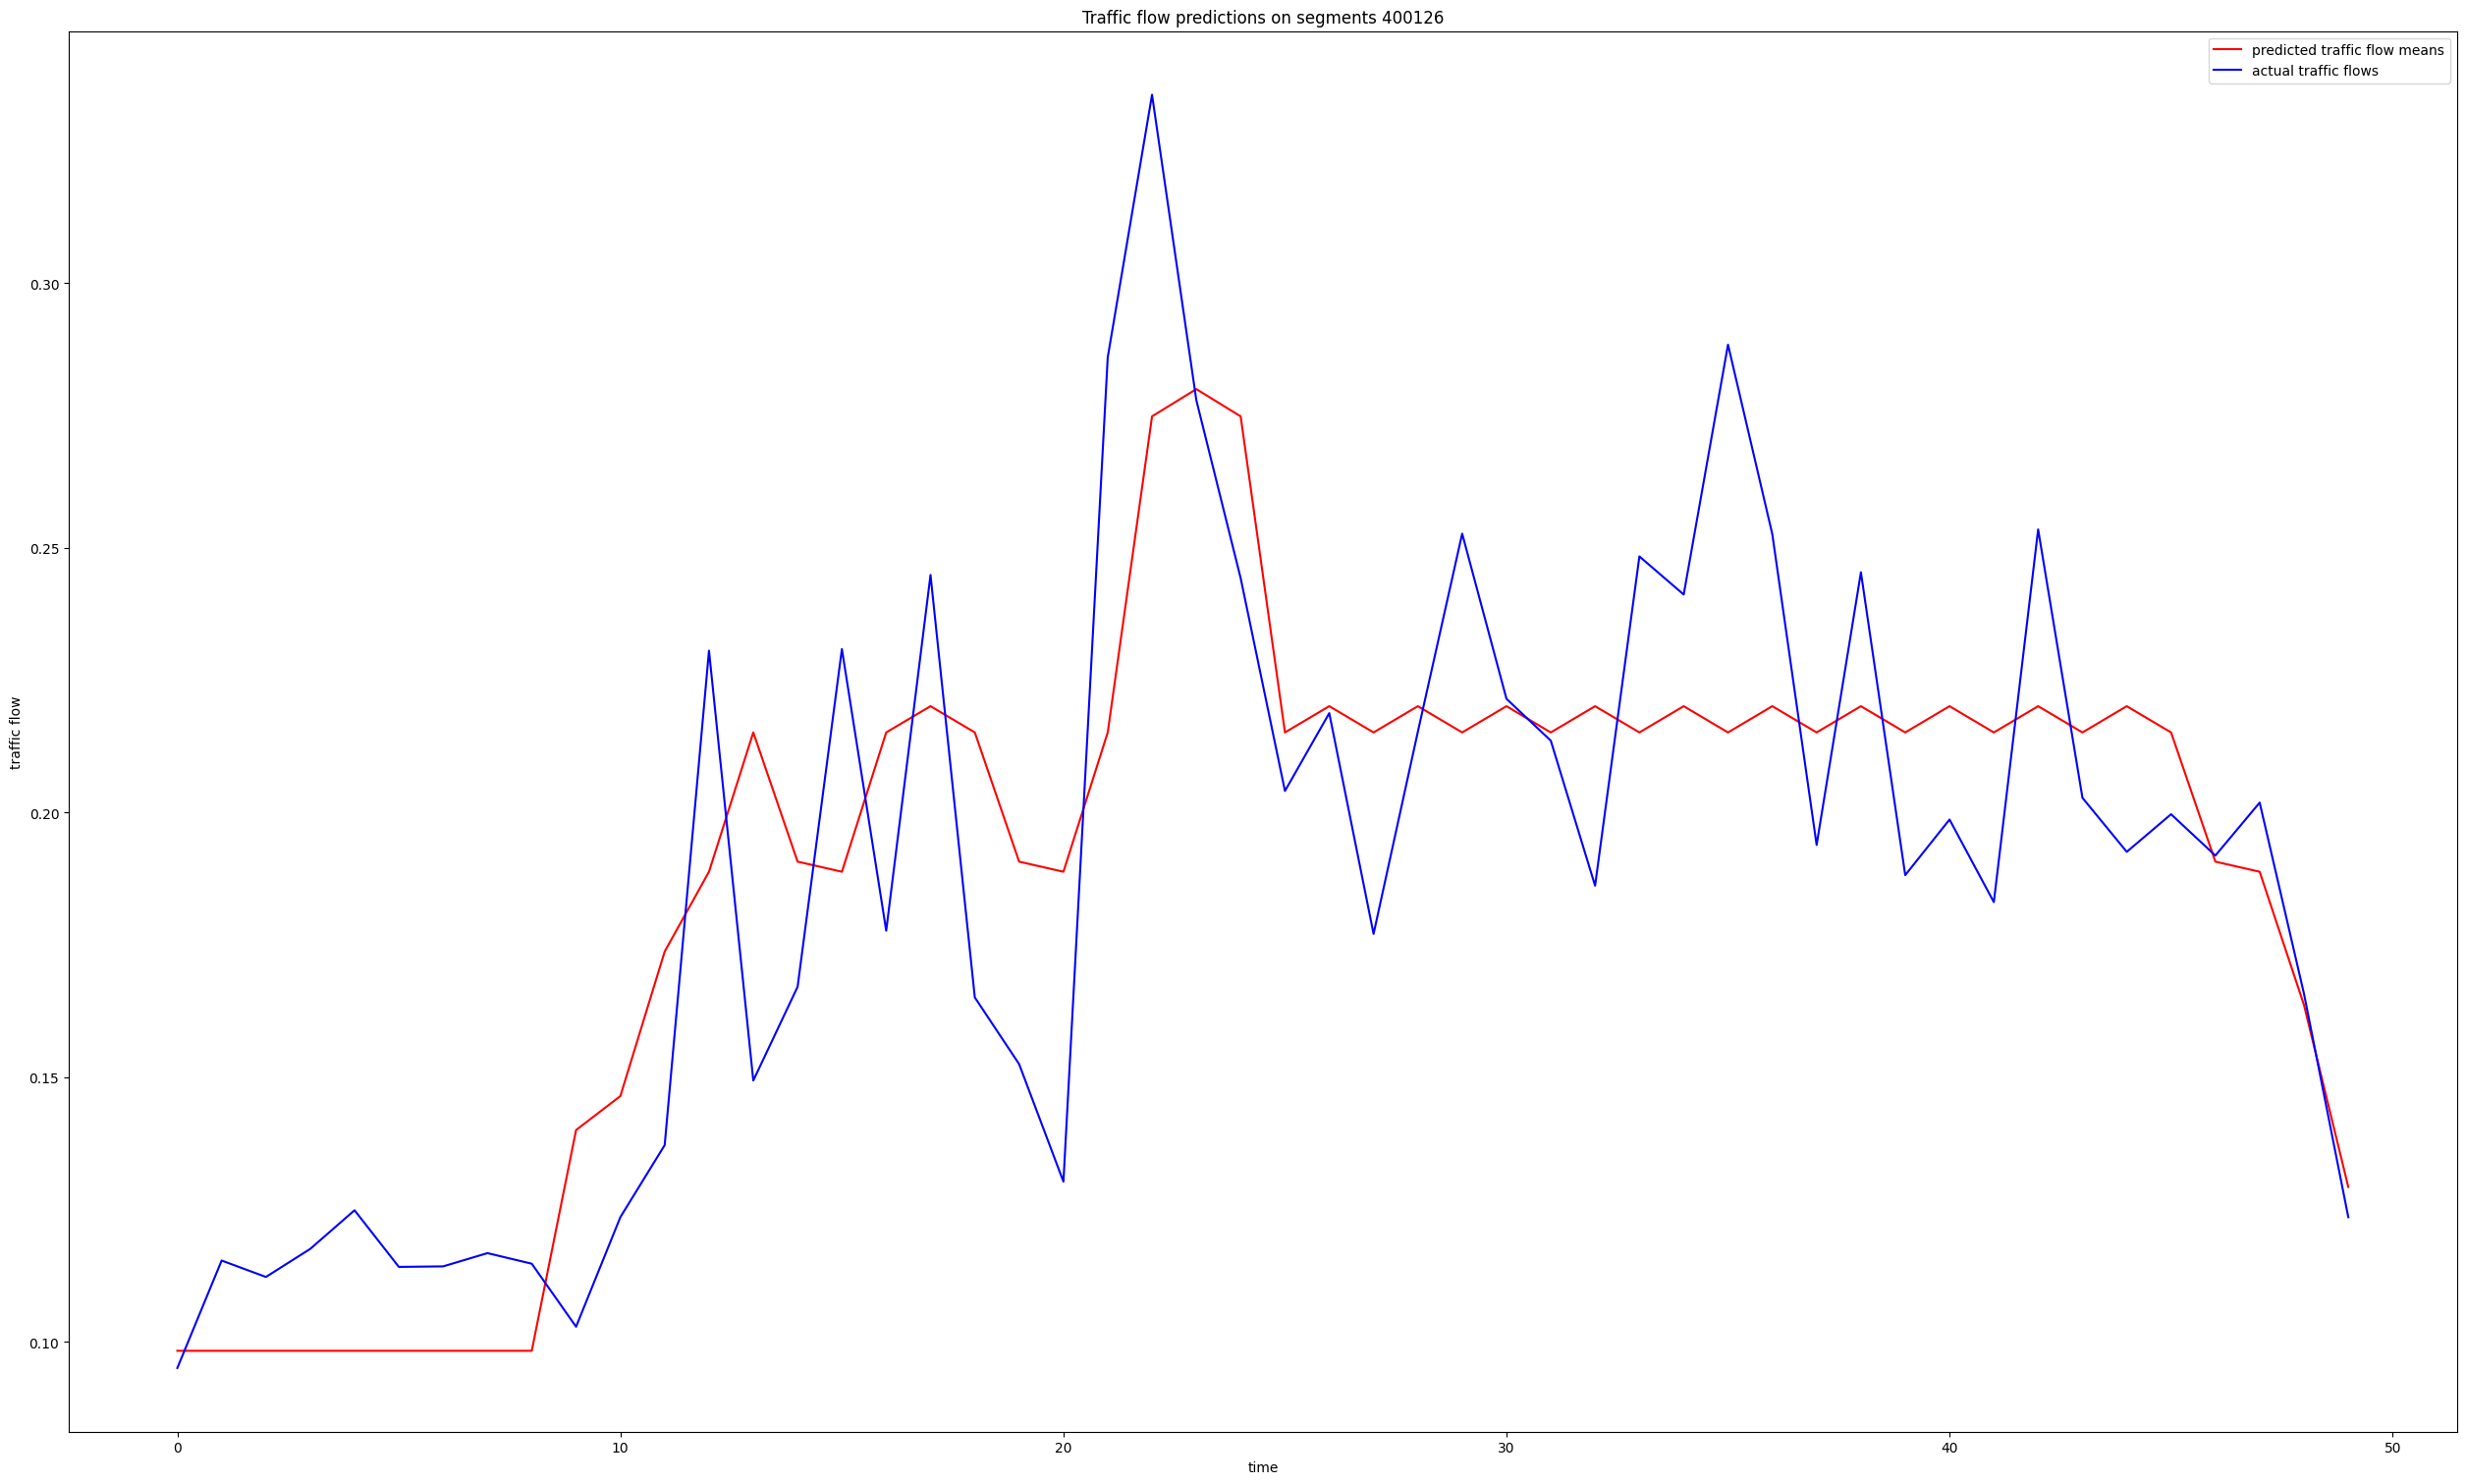

In [117]:
best_model = all_models[24]
best_model.predict_states()
predicted_flows = best_model.get_predicted_flows('400126')
plot_predicted_flows('400126', predicted_flows, 50)
#     def plot_predicted_flows(self, column, time_range, train_or_test='test'):
# best_model.predict_states_and_flows()
# best_model.plot_predicted_flows(column='400126', time_range=(0,50))

# one step ahead prediction - state depends only on previous state
# extend this to include variance on the plot 

even though the flow predictions look pretty good, i don't think the performance is particularly surprising. basically, the 4D actual traffic flows have been split into 24 different states, and each state's mean (for the HMM gaussian emission) is just the mean of the traffic flows that have in that state. here, the predictions (projected onto one dimension, aka one road segment) sortof just look like a mellowed-out / averaged version of the actual flows. 

In [107]:
# setting up data
selected_cols = ['400126','400176','400691','401242']
# testing out up to 24 hidden states --> possibly all 4! = 24 permutations of the 4 travel segments needed for accurate predictions
all_models_normalized = train_all_models(num_components_range=(15,25), covar_type='full', columns=selected_cols, train_test_split=0.7, normalize=True)

done training model <__main__.VHMM_Model object at 0x12cb91340> 
score = -185957.99067715925 
current time = 15:39:14 
-------------
done training model <__main__.VHMM_Model object at 0x12cfe1040> 
score = -180524.75649683375 
current time = 15:43:03 
-------------
done training model <__main__.VHMM_Model object at 0x13f9422e0> 
score = -177641.94340700452 
current time = 15:47:00 
-------------
done training model <__main__.VHMM_Model object at 0x13f9421f0> 
score = -177632.73436332803 
current time = 15:51:21 
-------------
done training model <__main__.VHMM_Model object at 0x13f942340> 
score = -172464.27162450823 
current time = 15:56:08 
-------------
done training model <__main__.VHMM_Model object at 0x13f942790> 
score = -174581.43452962075 
current time = 16:01:32 
-------------
done training model <__main__.VHMM_Model object at 0x12e501e50> 
score = -170513.29071530516 
current time = 16:07:29 
-------------
done training model <__main__.VHMM_Model object at 0x12cc142e0> 
scor

In [125]:
ax = sns.heatmap(best_model.model.transmat_, linewidth=0.5)
plt.show()

array([[9.31445925e-01, 2.76382887e-06, 2.76382887e-06, 2.76382887e-06,
        2.76382887e-06, 2.76382887e-06, 8.18298049e-03, 2.76382887e-06,
        6.42895373e-03, 2.76382887e-06, 2.76382898e-06, 4.85187038e-02,
        2.76382887e-06, 2.76382887e-06, 2.76382887e-06, 2.76382889e-06,
        2.76382887e-06, 2.76382887e-06, 2.76382890e-06, 2.76382888e-06,
        2.76382887e-06, 2.76382889e-06, 5.37092398e-03, 2.76382887e-06],
       [6.12078298e-03, 2.61741349e-06, 5.01245563e-04, 2.61741349e-06,
        4.70619073e-02, 2.61741350e-06, 2.61741349e-06, 2.61741350e-06,
        2.61741349e-06, 2.61741350e-06, 2.61741349e-06, 2.61741350e-06,
        2.61741349e-06, 2.61741349e-06, 2.61741350e-06, 7.13671263e-04,
        2.25486698e-01, 2.61741349e-06, 2.61741349e-06, 2.61741349e-06,
        7.20068581e-01, 2.61741349e-06, 2.61741350e-06, 2.61741349e-06],
       [2.43014313e-03, 2.43435085e-06, 8.57537535e-01, 2.43435085e-06,
        2.43435085e-06, 2.43435091e-06, 4.85319707e-03, 2.4343

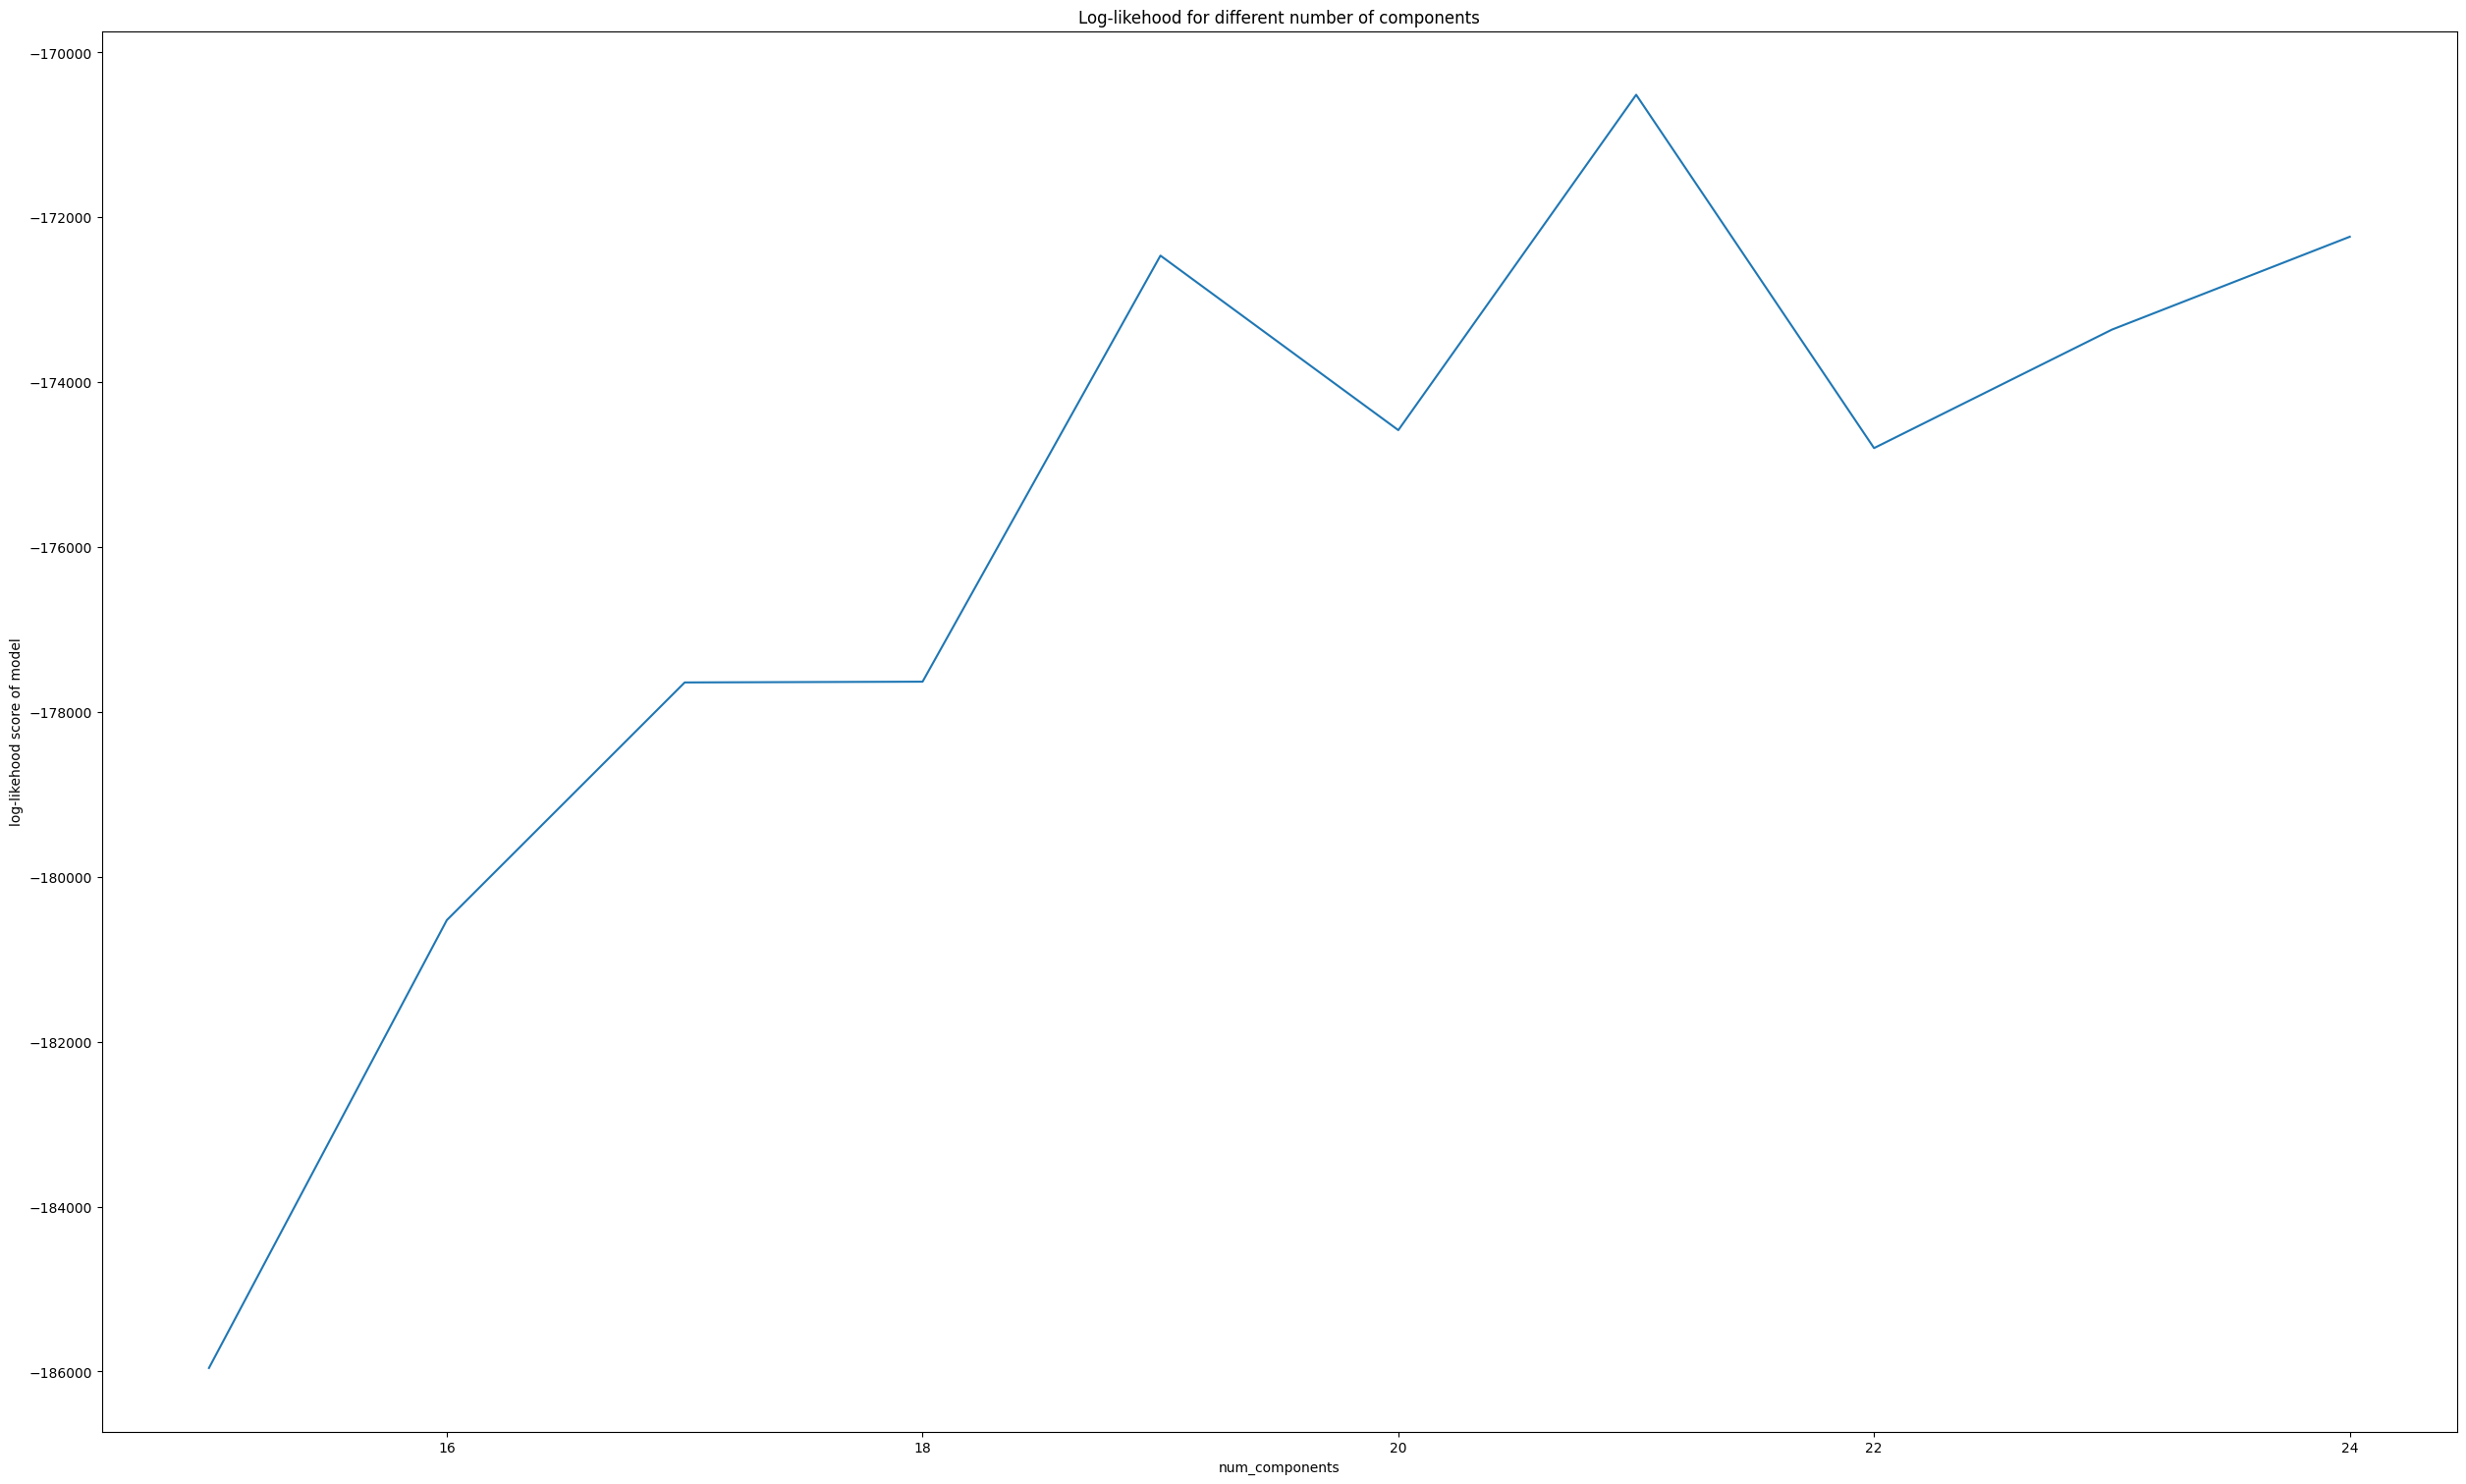

In [108]:
plot_model_scores(all_models_normalized)

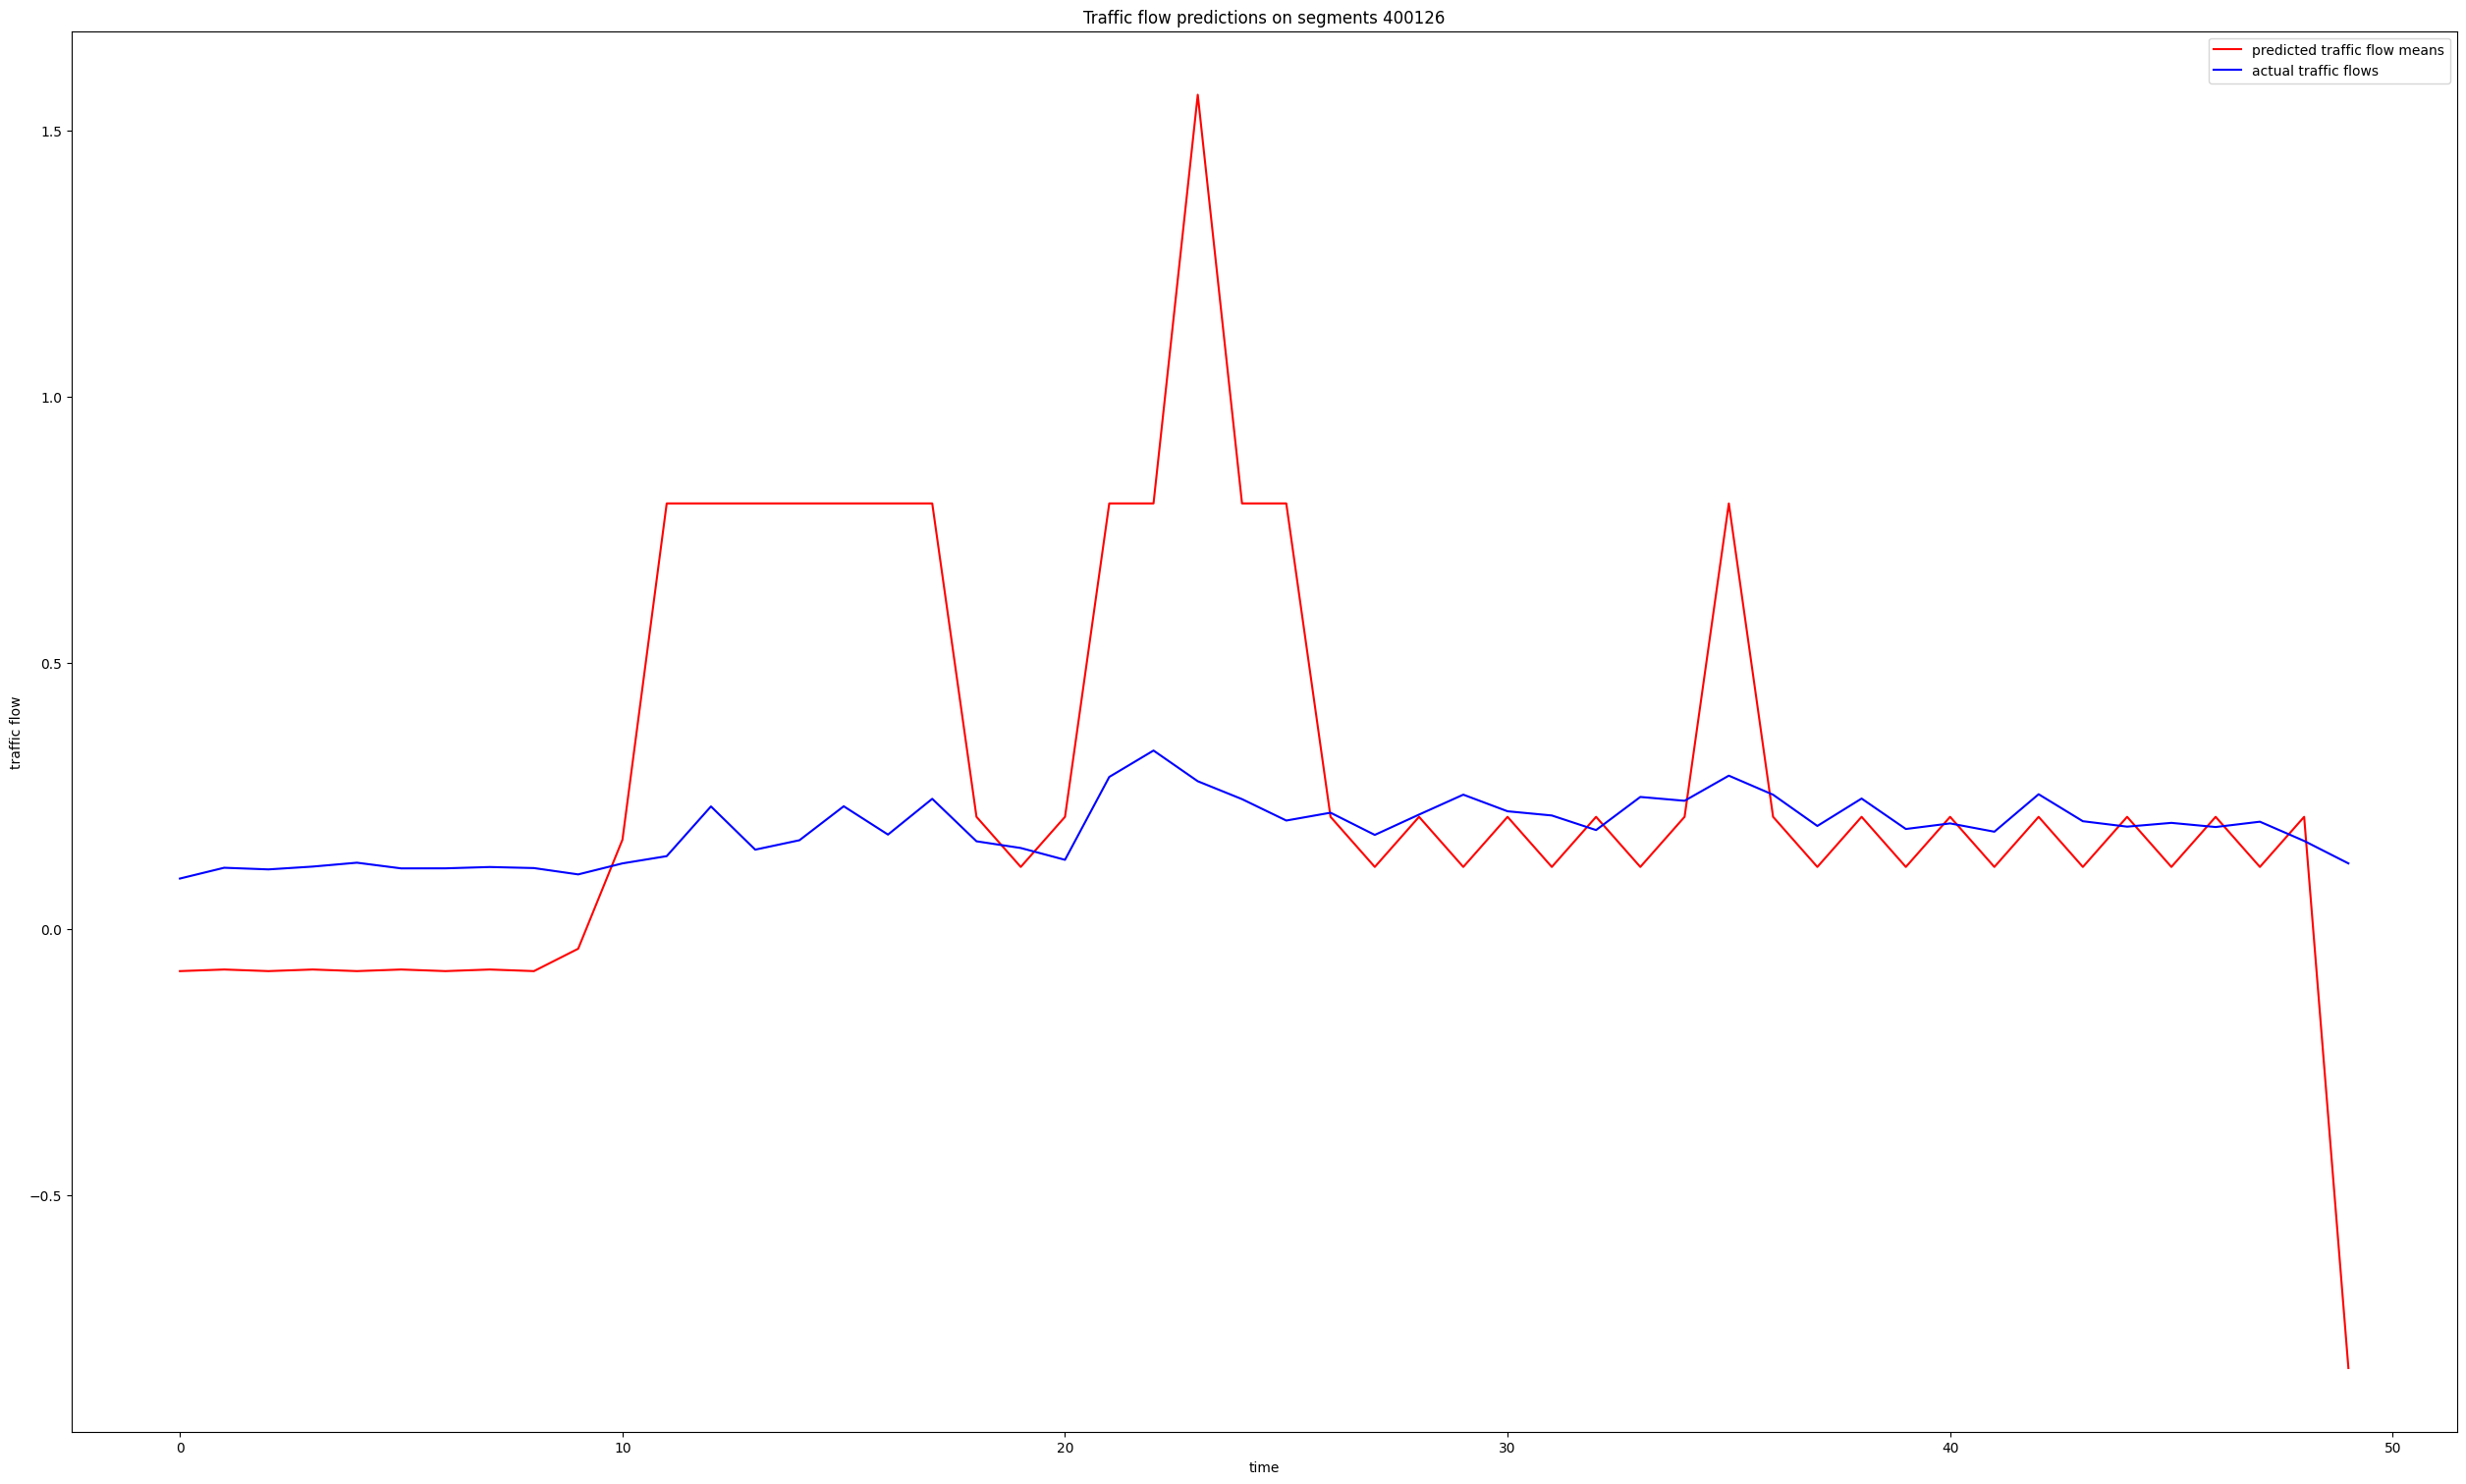

In [118]:
best_model_normalized = all_models_normalized[24]
best_model_normalized.predict_states()
predicted_flows = best_model_normalized.get_predicted_flows('400126')
plot_predicted_flows('400126', predicted_flows, 50)

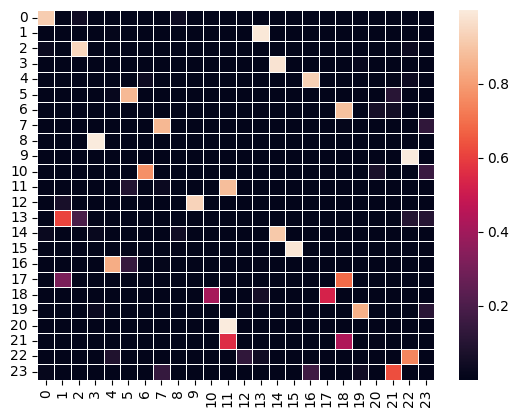

In [63]:
# plotting the transition matrix
import seaborn as sns
ax = sns.heatmap(transmat, linewidth=0.5)
plt.show()

the transition matrix is incredibly sparse - most of the parameters are close to 0. this is telling us that making the state space and thus transition matrix higher dimensional is probably not really helping us encode more information. rather, perhaps we should rely on a linear dynamical system with less parameters. a further advantage of LDS would be that the # of parameters scales with dimensionality of underlying space, not the number of hidden states, and thus we could still get essentially infinite hidden states while having to learn less parameters.

# normalizing out effects of demand

 (average flows of each 5m time interval over all days)

In [ ]:
# processing data (normalizing across days)
raw_data = pd.read_csv('~/UROP_transportation/data/I80_density.csv').dropna(axis=0)
flow_data = raw_data[['400126','400176','400691','401242','401698','405602']]
print(flow_data)

# flow_data_array = np.array(flow_data)
# print(f'flow data = {flow_data_array}, shape = {flow_data_array.shape}')

# n_samples = flow_data_array.shape[0]
# n_features = flow_data_array.shape[1]

# training_index = math.floor(n_samples * 0.7)
# training_data = flow_data_array[0:training_index]
# testing_data = flow_data_array[training_index:]

some notes about future models:
- means plot is not actually a prediction question, just another way of evaluating the model on observed 
- forecasting 2 hours ahead - basically simulate the trained model on the e.g. 30m before the 
    - compare # of components vs. forecasting ability
- benchmark against non-parametric models (NNs, SGDs, random forests)
- try using linear dynamical system model (basically hidden markov model, except hidden states evolve according to a fixed linear transformation at each time step with the addition of some small gaussian noise)
- look into perhaps models that allow more custom specification of underlying hidden states - perhaps discrete sets of continuous spaces? where one space corresponds to traffic flow evolution during no incidents, the other corresponds to incidents


combining HMM with linear regression 'emissions'
- most important next step: evaluate forecasting many timesteps ahead (i.e. 1 hour = 12 timesteps)